In [1]:
# imports
from isweeptest import *
import matplotlib.pyplot as plt

In [19]:
def walk_variant_forward_tv(s_s, g_s, pG, Ne, random_walk = False, ploidy = 2):
    '''Variant frequencies forward in time

    Parameters
    ----------
    s_s : list
        List of selection coefficients
    g_s : list
        List of transition times for selection coefficients
        This should be aligned with the s_s parameter
            e.g., s_s=[0.01,0.03,0.02] and g_s=[50,100] means 
            s=0.02 between 100-, s=0.03 between 100-50 and s=0.01 between 50-0
        Should be length one less than s_s
    pG : float
        Variant frequency at maximum generation
    Ne : dict
        Effective population sizes
    random_walk : bool
        True for random walk
    ploidy : int
        1 for haploid or 2 for diploid

    Additive genic selection is assumed

    Returns
    -------
    tuple
        NumPy arrays for frequencies and sizes
    '''

    # local functions
    assert ploidy in [1,2]
    def haploid_fwd(p, s): # haploid is same as multiplicative
        return p * (1 + s) / (1 + p * s)
    def additive_fwd(p, s):
        num = 1 + s + p * s
        dnm = 1 + 2 * p * s
        return p * num / dnm

    # one step calculation
    if ploidy == 1:
        one_step = haploid_fwd
    else:
        one_step = additive_fwd

    # initialize
    ps = [] # frequencies
    xs = [] # variants
    Ns = [] # sizes
    p = pG
    G = max(Ne.keys())
    assert len(s_s) == (len(g_s) + 1)
    s = s_s[-1]
    s_s.pop(-1)
    sdict = {g_s[i]:s_s[i] for i in range(len(g_s))}
    N = Ne[G]
    x = ceil(p * ploidy * N)
    Ns.append(N)
    xs.append(x)
    ps.append(p)

    if random_walk: # random walk

        while G >= 0:
            G -= 1
            try:
                N = Ne[G]
            except KeyError:
                pass
            try:
                s = sdict[G]
            except KeyError:
                pass
            p = one_step(p, s)
            x = int(binom.rvs(int(ploidy * N), p))
            p = x / ploidy / N
            if x < 1:
                break
            if p >= 1:
                break
            ps.append(p)
            xs.append(x)
            Ns.append(N)

        return np.array([np.array(ps), np.array(Ns), np.array(xs)]) # numpy-ify

    else: # deterministic

        while G >= 0:
            G -= 1
            try:
                N = Ne[G]
            except KeyError:
                pass
            try:
                s = sdict[G]
            except KeyError:
                pass
            p = one_step(p, s)
            x = floor(p * ploidy * N)
            if x < 1:
                break
            if p >= 1:
                break
            Ns.append(N)
            xs.append(x)
            ps.append(p)

        return np.array([np.array(ps), np.array(Ns), np.array(xs)]) # numpy-ify


In [2]:
Ne = read_Ne('three-phase-500G.ne')
mxG = max(Ne.keys())
p = 1 / Ne[mxG]
print(p)

0.0002


(0.0, 1.0)

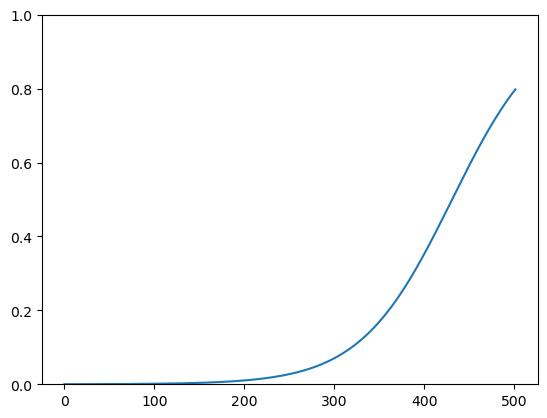

In [3]:
abc = walk_variant_forward_tv([0.02],[],p,Ne,random_walk=False)
plt.plot(range(len(abc[0])),abc[0])
# plt.axvline(450)
# plt.axvline(480)
# plt.axvline(490)
plt.ylim(0,1)
# plt.xlim(300,500)

In [128]:
def walk_variant_backward_tv(s_s, g_s, p0, Ne, random_walk = False, ploidy = 2):
    '''Variant frequencies backward in time

    Parameters
    ----------
    s_s : list
        List of selection coefficients
    g_s : list
        List of transition times for selection coefficients
        This should be aligned with the s_s parameter
            e.g., s_s=[0.01,0.03,0.02] and g_s=[50,100] means 
            s=0.01 between 0-50, s=0.03 between 50-100 and s=0.02 between 100-
        Should be length one less than s_s
    p0 : float
        Variant frequency at generation 0
    Ne : dict
        Effective population sizes
    random_walk : bool
        True for random walk
    ploidy : int
        1 for haploid or 2 for diploid


    Returns
    -------
    tuple
        NumPy arrays for frequencies and sizes
    '''

    # local functions
    assert ploidy in [1,2]
    assert p0 <= 1
    assert p0 >= 0
    def haploid_bwd(p, s): # haploid is same as multiplicative (Felsenstein, 2017)
        return p / (1 + s - s * p)
    def additive_bwd(p, s):
        a = s
        b = 1 + s - 2 * p * s
        c = - p
        qf = - b + sqrt((b ** 2) - 4 * a * c)
        qf = qf / 2 / a
        return qf

    # one step calculation
    if ploidy == 1:
        one_step = haploid_bwd
    else:
        one_step = additive_bwd

    # initialize
    ps = [] # frequencies
    xs = [] # variants
    Ns = [] # sizes
    p = p0
    N = Ne[0]
    assert len(s_s) == (len(g_s)+1)
    s = s_s[0]
    s_s.pop(0)
    sdict = {g_s[i]:s_s[i] for i in range(len(g_s))}
    x = floor(p * ploidy * N)
    Ns.append(N)
    xs.append(x)
    ps.append(p)

    if random_walk: # random walk

        for G in range(1, max(Ne.keys())+1):
            try: # population size change
                N = Ne[G]
            except KeyError:
                pass
            try:
                s = sdict[G]
            except KeyError:
                pass
            p = one_step(p, s)
            x = int(binom.rvs(int(ploidy * N), p))
            p = x / ploidy / N
            if x < 1:
                break
            if p >= 1:
                break
            ps.append(p)
            xs.append(x)
            Ns.append(N)

        return np.array([ps, Ns, xs], dtype=float) # numpy-ify

    else: # deterministic

        for G in range(1, max(Ne.keys())+1):
            try: # population size change
                N = Ne[G]
            except KeyError:
                pass
            try:
                s = sdict[G]
            except KeyError:
                pass
            p = one_step(p, s)
            x = floor(p * ploidy * N)
            if x < 1:
                break
            if p >= 1:
                break
            Ns.append(N)
            xs.append(x)
            ps.append(p)

        return np.array([np.array(ps), np.array(Ns), np.array(xs)]) # numpy-ify

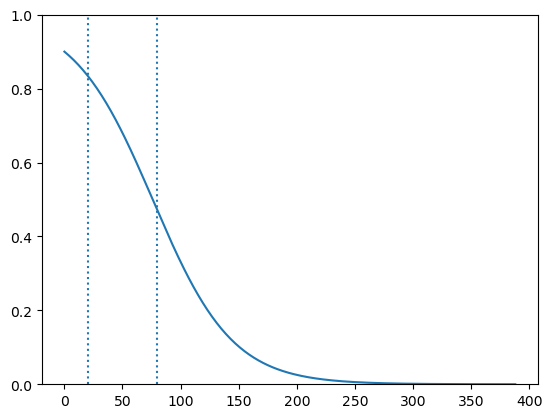

In [4]:
p=0.9
abc = walk_variant_backward_tv([0.03],[],p,Ne,random_walk=False)
plt.plot(range(len(abc[0])),abc[0])
plt.ylim(0,1)
plt.axvline(20,linestyle='dotted')
plt.axvline(80,linestyle='dotted')

In [ ]:
def chi2_isweep_tv(s_s, g_s, p0, Ne, n, obs, ab, ploidy = 2):
    '''Chi-squared statistic for sweep model (unlabeled)

    Parameters
    ----------
    s_s : list
        List of selection coefficients
    g_s : list
        List of transition times for selection coefficients
        This should be aligned with the s_s parameter
            e.g., s_s=[0.01,0.03,0.02] and g_s=[50,100] means 
            s=0.01 between 0-50, s=0.03 between 50-100 and s=0.02 between 100-
        Should be length one less than s_s
    p0 : float
        Variant frequency at generation 0
    Ne : dict
        Effective population sizes
    n : int
        Pairs sample size
    obs : array-like
        Observed counts for ibd segment bins (unlabeled)
    ab : array-like
        Increasing floats in centiMorgans
    one_step_model : str
        'm', 'a', 'd', or 'r'
    ploidy : int
        1 for haploid or 2 for diploid

    Returns
    -------
    float
        Goodness-of-fit statistic
    '''

    assert len(obs) == (len(ab) - 1)
    ps, Ns, xs = walk_variant_backward_tv(s_s, g_s, p0, Ne, False, ploidy)
    mass1 = (ps[0] ** 2) * probability_quasi_geometric(ps, Ns, ploidy)
    mass0 = ((1 - ps[0]) ** 2) * probability_quasi_geometric(1 - ps, Ns, ploidy)
    E0 = probability_erlang_segments(ab, mass0)
    E1 = probability_erlang_segments(ab, mass1)
    E = E1 + E0
    E = n * E
    OE = ((obs - E) ** 2) / E

    return np.sum(OE)

In [ ]:
def regularized_optim_isweep_tv(beta0, beta1, p0, Ne, n, obs, ab, ploidy = 2):
    '''
    Estiming time-varying selection with regularization

    Parameters
    ----------
    See help(chi2_isweep_tv)
    beta0: float
        Regularizing constant for number of parameters
    beta1: float
        Regularizing constant for Euclidean norm for s vector

    Returns
    -------
    list
        Regularized loss
    '''

    def chi2_regularized_isweep_tv(s_s, g_s, p0, Ne, n, obs, ab, ploidy = 2, beta1=beta1):
        pearson = chi2_isweep_tv = (s_s,g_s,p0,Ne,n,obs,ab,ploidy)
        regularized = 0
        for i in range(len(s_s)-1):
            regularized += (beta1 * abs(s_s[i] - s_s[i+1]))
        return pearson + regularized
    
    itr = 0
    results = dict()

    # option zero
    g_s = []
    x0 = [0.01,]
    bds = [(0.,1.) for i in range(len(g_s)+1)]
    optim = minimize(chi2_regularized_isweep_tv,
                     x0 = x0,
                     args = (g_s, p0, Ne, n, obs, ab, ploidy, beta1),
                     bounds = bds
                    )
    results[itr] = {'fitted':optim.x,
                    'g_s':g_s,
                    'loss':optim.fun + beta0 * len(x0),
                    'betas':(beta0,beta1),
                    'OptimizeResult':[]
                   }
    itr +=1
    
    # option one
    g_s = [20]
    x0 = [0.01 for i in range(len(g_s)+1)]
    bds = [(0.,1.) for i in range(len(g_s)+1)]
    optim = minimize(chi2_regularized_isweep_tv,
                     x0 = x0,
                     args = (g_s, p0, Ne, n, obs, ab, ploidy, beta1),
                     bounds = bds
                    )
    results[itr] = {'fitted':optim.x,
                    'g_s':g_s,
                    'loss':optim.fun + beta0 * len(x0),
                    'betas':(beta0,beta1),
                    'OptimizeResult':[]
                   }
    itr +=1

    # option two
    g_s = [50]
    x0 = [0.01 for i in range(len(g_s)+1)]
    bds = [(0.,1.) for i in range(len(g_s)+1)]
    optim = minimize(chi2_regularized_isweep_tv,
                     x0 = x0,
                     args = (g_s, p0, Ne, n, obs, ab, ploidy, beta1),
                     bounds = bds
                    )
    results[itr] = {'fitted':optim.x,
                    'g_s':g_s,
                    'loss':optim.fun + beta0 * len(x0),
                    'betas':(beta0,beta1),
                    'OptimizeResult':[]
                   }
    itr +=1

    # option three
    g_s = [20,100]
    x0 = [0.01 for i in range(len(g_s)+1)]
    bds = [(0.,1.) for i in range(len(g_s)+1)]
    optim = minimize(chi2_regularized_isweep_tv,
                     x0 = x0,
                     args = (g_s, p0, Ne, n, obs, ab, ploidy, beta1),
                     bounds = bds
                    )
    results[itr] = {'fitted':optim.x,
                    'g_s':g_s,
                    'loss':optim.fun + beta0 * len(x0),
                    'betas':(beta0,beta1),
                    'OptimizeResult':[]
                   }
    itr +=1

    # option four
    g_s = [50,100]
    x0 = [0.01 for i in range(len(g_s)+1)]
    bds = [(0.,1.) for i in range(len(g_s)+1)]
    optim = minimize(chi2_regularized_isweep_tv,
                     x0 = x0,
                     args = (g_s, p0, Ne, n, obs, ab, ploidy, beta1),
                     bounds = bds
                    )
    results[itr] = {'fitted':optim.x,
                    'g_s':g_s,
                    'loss':optim.fun + beta0 * len(x0),
                    'betas':(beta0,beta1),
                    'OptimizeResult':[]
                   }
    itr +=1

    # option five
    g_s = [33,67,100]
    x0 = [0.01 for i in range(len(g_s)+1)]
    bds = [(0.,1.) for i in range(len(g_s)+1)]
    optim = minimize(chi2_regularized_isweep_tv,
                     x0 = x0,
                     args = (g_s, p0, Ne, n, obs, ab, ploidy, beta1),
                     bounds = bds
                    )
    results[itr] = {'fitted':optim.x,
                    'g_s':g_s,
                    'loss':optim.fun + beta0 * len(x0),
                    'betas':(beta0,beta1),
                    'OptimizeResult':[]
                   }
    itr +=1

    # option six
    g_s = [20,40,60,80,100]
    x0 = [0.01 for i in range(len(g_s)+1)]
    bds = [(0.,1.) for i in range(len(g_s)+1)]
    optim = minimize(chi2_regularized_isweep_tv,
                     x0 = x0,
                     args = (g_s, p0, Ne, n, obs, ab, ploidy, beta1),
                     bounds = bds
                    )
    results[itr] = {'fitted':optim.x,
                    'g_s':g_s,
                    'loss':optim.fun + beta0 * len(x0),
                    'betas':(beta0,beta1),
                    'OptimizeResult':[]
                   }
    itr +=1

    # option seven
    g_s = [10,20,30,40,50,75,100]
    x0 = [0.01 for i in range(len(g_s)+1)]
    bds = [(0.,1.) for i in range(len(g_s)+1)]
    optim = minimize(chi2_regularized_isweep_tv,
                     x0 = x0,
                     args = (g_s, p0, Ne, n, obs, ab, ploidy, beta1),
                     bounds = bds
                    )
    results[itr] = {'fitted':optim.x,
                    'g_s':g_s,
                    'loss':optim.fun + beta0 * len(x0),
                    'betas':(beta0,beta1),
                    'OptimizeResult':[]
                   }
    itr +=1

    return results

In [ ]:
def simulate_ibd_isweep_tv(n, s_s, g_s, p0, Ne, long_ibd=2.0, short_ibd=1.0, random_walk=True, ploidy=2, record_dist=True, pairwise_output=True):
    '''ibd segments from a coalescent with selection

    Parameters
    ----------
    n : int
        Sample size (individuals)
    s_s : list
        List of selection coefficients
    g_s : list
        List of transition times for selection coefficients
        This should be aligned with the s_s parameter
            e.g., s_s=[0.01,0.03,0.02] and g_s=[50,100] means 
            s=0.01 between 0-50, s=0.03 between 50-100 and s=0.02 between 100-
        Should be length one less than s_s
    p0 : float
        Variant frequency at generation 0
    Ne : dict
        Effective population sizes
    long_ibd, short_ibd : float
        cM length threshold
    random_walk : bool
        True for random walk
    ploidy : int
        1 for haploid or 2 for diploid
    record_dist : bool
        To save tract length and coalescent time distributions or not to (default True)
    pairwise_output : bool
        To save pairwise segments or not to (default True)

    Returns
    -------
    tuple(s)
        (all, adaptive allele, non-adaptive allele) then pairwise segments
        Each tuple is (number of tracts, group sizes, length distr., time distr., count distr.)
    '''

    assert ploidy in [1,2]
    assert long_ibd > 0
    assert short_ibd > 0
    assert long_ibd >= short_ibd
    assert p0 <= 1
    assert p0 >= 0

    global H, H1, H0, ldist, ldist1, ldist0, tdist1, tdist0, tdist, ddist1, ddist0, ddist
    global pairwise_segments
    pairwise_segments = []
    H1 = nx.Graph()
    H0 = nx.Graph()
    ldist1 = []
    ldist0 = []
    tdist1 = []
    tdist0 = []
    ddist1 = []
    ddist0 = []

    # renaming
    p = p0
    stoc = random_walk
    Ne = cut_Ne(to_max_Ne(fill_Ne(Ne),500),2000)

    # should p0 be fixed
    if (p0 == 0) or (p0 == 1):
        out = simulate_ibd(n, Ne,
                           long_ibd, short_ibd,
                           ploidy, continuous_time,
                           record_dist, pairwise_output
                          )
        # numpy-ify
        return (out,
                (np.nan,np.array([]),np.array([]),np.array([]),np.array([])),
                (np.nan,np.array([]),np.array([]),np.array([]),np.array([])),
                tuple(pairwise_segments)
               )

    # calculating structured demographies
    ps, Ns, xs = walk_variant_backward_tv(s_s, g_s, p, Ne, stoc, ploidy)
    n = int(float(n))
    n = n * ploidy
    G = max(Ne.keys())
    n1 = floor(n * ps[0])
    n0 = n - n1
    N1 = [ceil(i) for i in Ns * ps]
    N1 = {i:N1[i] for i in range(len(N1))}
    qs = extend_vector(1 - ps, 1, G)
    Ns = np.array(list(Ne.values()))
    N0 = [ceil(i) for i in Ns * qs]
    N0 = {i:N0[i] for i in range(len(N0))}

    # arrival times
    times1 = simulate_coalgen(n1, N1, ploidy, to_tmrca=False)
    interiors1 = [Node(i, 0, pairwise_output) for i in range(n1)]
    interiors0 = [Node(i, 0, pairwise_output) for i in range(n1,n1+n0)]

    # pairwise comparisons pop 1
    m = n1
    indxs = [i for i in range(m)]
    itr = n1 + n0
    for t in times1:
        m -= 1
        new_node = Node(itr, t, pairwise_output)
        sindx = sorted(two_randint(m))
        s1 = sindx[0]
        s2 = sindx[1]
        new_node.pair_coalesce(interiors1[s1], interiors1[s2], long_ibd, short_ibd, 1, record_dist, pairwise_output)
        interiors1.append(new_node)
        interiors1.pop(s1)
        interiors1.pop(s2-1)
        indxs.pop(s1)
        indxs.pop(s2-1)
        indxs.append(itr)
        itr += 1
    numTracts1 = sum([node._num_tracts for node in interiors1])
    ibdGroupSizes1 = sorted([len(c) for c in nx.connected_components(H1)],reverse=True)

    # pairwise comparisons p0
    maxt1=max([node._time for node in interiors1])
    N00 = {key:val for key,val in N0.items() if key <= maxt1}
    N01 = {key:val for key,val in N0.items() if key > maxt1}
    times0 = simulate_coalgen(n0, N00, ploidy, to_tmrca=False)
    m = n0
    indxs = [i for i in range(m)]
    for t in times0:
        m -= 1
        new_node = Node(itr, t, pairwise_output)
        sindx = sorted(two_randint(m))
        s1 = sindx[0]
        s2 = sindx[1]
        new_node.pair_coalesce(interiors0[s1], interiors0[s2], long_ibd, short_ibd, 0, record_dist, pairwise_output)
        interiors0.append(new_node)
        interiors0.pop(s1)
        interiors0.pop(s2-1)
        indxs.pop(s1)
        indxs.pop(s2-1)
        indxs.append(itr)
        itr += 1
    numTracts0 = sum([node._num_tracts for node in interiors0])
    ibdGroupSizes0 = sorted([len(c) for c in nx.connected_components(H0)],reverse=True)

    # arrival times, pairwise comparisons to TMRCA
    H = nx.compose(H1,H0)
    ldist = [*ldist1, *ldist0]
    tdist = [*tdist1, *tdist0]
    ddist = [*ddist1, *ddist0]
    interiors = interiors1 + interiors0
    m = len(interiors)
    indxs = [i for i in range(m)]
    if len(N01.keys()) > 0:
        times2 = simulate_coalgen(m, N01, ploidy, to_tmrca=True)
        for t in times2:
            m -= 1
            new_node = Node(itr, t, pairwise_output)
            sindx = sorted(two_randint(m))
            s1 = sindx[0]
            s2 = sindx[1]
            new_node.pair_coalesce(interiors[s1], interiors[s2], long_ibd, short_ibd, 2, record_dist, pairwise_output)
            interiors.append(new_node)
            interiors.pop(s1)
            interiors.pop(s2-1)
            indxs.pop(s1)
            indxs.pop(s2-1)
            indxs.append(itr)
            itr += 1
    numTracts = sum([node._num_tracts for node in interiors])
    ibdGroupSizes = sorted([len(c) for c in nx.connected_components(H)],reverse=True)

    # numpy-ify
    return ((numTracts,np.array(ibdGroupSizes),np.array(ldist),np.array(tdist),np.array(ddist)),
            (numTracts1,np.array(ibdGroupSizes1),np.array(ldist1),np.array(tdist1),np.array(ddist1)),
            (numTracts0,np.array(ibdGroupSizes0),np.array(ldist0),np.array(tdist0),np.array(ddist0)),
            tuple(pairwise_segments)
           )

In [150]:
basic_coalescent(1000)*100000

array([2.77047960e-03, 1.98498795e-01, 6.77568932e-01, 8.60427945e-01,
       9.77839664e-01, 1.10089478e+00, 1.41917835e+00, 1.65851543e+00,
       1.66901619e+00, 1.70989795e+00, 1.79035301e+00, 1.97802768e+00,
       2.04118312e+00, 2.04438197e+00, 2.13361095e+00, 2.29231558e+00,
       2.37955508e+00, 2.68567766e+00, 2.80406495e+00, 2.86203145e+00,
       3.19213559e+00, 3.31848012e+00, 3.63857100e+00, 3.97617723e+00,
       4.06377106e+00, 4.15629101e+00, 4.26186101e+00, 4.28507486e+00,
       4.28774353e+00, 4.46022067e+00, 4.73051349e+00, 4.92195523e+00,
       5.48833596e+00, 6.34730458e+00, 6.78120642e+00, 7.07374331e+00,
       7.13427864e+00, 7.20248876e+00, 7.77463729e+00, 8.70775957e+00,
       8.76913650e+00, 9.71422087e+00, 1.00847862e+01, 1.01059621e+01,
       1.06430611e+01, 1.07179628e+01, 1.08220232e+01, 1.10912871e+01,
       1.12385700e+01, 1.14752968e+01, 1.16776156e+01, 1.17335176e+01,
       1.20416316e+01, 1.21278223e+01, 1.23561390e+01, 1.23621380e+01,
      

In [ ]:
def simulate_ibd_constant(n, Ne, long_ibd=2.0, short_ibd=1.0, ploidy=2, record_dist=True, pairwise_output=True):
    '''ibd segments from a coalescent w/ constant Ne

    Parameters
    ----------
    n : int
        Sample size (individuals)
    Ne : numeric
        Constant effective population size
    long_ibd, short_ibd : float
        cM length threshold
    ploidy : int
        1 for haploid or 2 for diploid
    record_dist : bool
        To save tract length and coalescent time distributions or not to (default True)
    pairwise_output : bool
        To save pairwise segments or not to (default True)

    Returns
    -------
    tuple
        (number of tracts, group sizes, length distr., time distr., count distr., pairwise segments)
    '''

    # checks
    assert long_ibd > 0
    assert short_ibd > 0
    assert long_ibd >= short_ibd
    n = int(float(n))
    ploidy = int(float(ploidy))

    # initialize graph network
    global H, H1, H0, ldist, ldist1, ldist0, tdist1, tdist0, tdist, ddist1, ddist0, ddist
    global pairwise_segments
    pairwise_segments = []
    H = nx.Graph()
    ldist = []
    ddist = []
    tdist = []

    # initalize
    m = ploidy*n
    interiors = [Node(i, 0, pairwise_output) for i in range(m)]
    itr = m

    # simulate times
    Ne=cut_Ne(to_max_Ne(fill_Ne(Ne),500),2000)
    # this is the simple change
    # do basic coalescent instead of wright-fisher
    times = basic_coalescent(m) * float(int(Ne))

    indxs = [i for i in range(m)]
    for t in times:
        m -= 1
        new_node = Node(itr, t, pairwise_output)
        sindx = sorted(two_randint(m))
        s1 = sindx[0]
        s2 = sindx[1]
        new_node.pair_coalesce(interiors[s1], interiors[s2], long_ibd, short_ibd, 2, record_dist)
        interiors.append(new_node)
        interiors.pop(s1)
        interiors.pop(s2-1)
        indxs.pop(s1)
        indxs.pop(s2-1)
        indxs.append(itr)
        itr += 1

    numTracts = sum([node._num_tracts for node in interiors])
    ibdGroupSizes = sorted([len(c) for c in nx.connected_components(H)],reverse=True)

    # tract count, group sizes, distributions: lengths, times, density
    return (numTracts,
            np.array(ibdGroupSizes),
            np.array(ldist),
            np.array(tdist),
            np.array(ddist),
            tuple(pairwise_segments)
           )